# Formatting Train Data

In [190]:
import pandas as pd 
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression

In [191]:
def grab_labelled_data(data_path, label_begins = 98): 
  labelled = pd.read_csv(data_path)
  label_begins = 98

  features = labelled.iloc[:, 2:label_begins] 
  labels = labelled.iloc[:, label_begins:]
  ids = labelled.iloc[:, :2]

  labels.columns = [x[10:] for x in labels.columns]

  features = features.join(ids)
  labels = labels.join(ids)

  features.columns.name = 'Time' 
  labels.columns.name = 'Time'

  features = features.pivot_table(index = ['Student ID', 'Date'])
  labels = labels.pivot_table(index = ['Student ID', 'Date'])

  features = pd.DataFrame(features.stack()).reset_index()
  labels = pd.DataFrame(labels.stack()).reset_index()

  time_stamps = features['Date'] + " " + features['Time']
  time_stamps = pd.to_datetime(time_stamps)

  features['Datetime'] = time_stamps
  labels['Datetime'] = time_stamps

  features = features.drop(columns = ['Date', 'Time'] ) 
  labels = labels.drop(columns = ['Date', 'Time'])

  features = features.pivot_table(index = ['Student ID', 'Datetime']) 
  labels = labels.pivot_table(index = ['Student ID', 'Datetime'])

  features.columns = ['Steps'] 
  labels.columns = ['Asleep']

  labelled_data = features.join(labels)

  return labelled_data 

In [192]:
labelled_data = grab_labelled_data('./BMCM_steps_sleep.csv')

In [193]:
labelled_data['Steps'] = labelled_data['Steps'].rolling(4).mean()

In [194]:
student_ids = range(0, 100)

In [195]:
backward_window = 4
forward_window = 2

In [196]:
train_data = pd.DataFrame() 
  
for student_id in student_ids: 
  labelled_data_for_student = labelled_data.loc[[student_id]]

  for dt in range(-backward_window, forward_window+1): 
    labelled_data_for_student.insert(dt+backward_window, "Steps_{}".format(dt), labelled_data_for_student['Steps'].shift(-dt)) 

  labelled_data_for_student = labelled_data_for_student.drop(columns = ['Steps']) 
  train_data = train_data.append(labelled_data_for_student)

In [197]:
train_data.index = [np.array([x[0] for x in train_data.index]), np.array([x[1] for x in train_data.index])]

In [198]:
train_data = train_data.dropna()

In [199]:
train_data

Steps_-4  Steps_-3  Steps_-2  ...  Steps_1  Steps_2  Asleep
0  2021-10-01 01:45:00     49.50     52.00     46.00  ...    29.50    10.75       1
   2021-10-01 02:00:00     52.00     46.00     41.75  ...    10.75    17.00       1
   2021-10-01 02:15:00     46.00     41.75     29.75  ...    17.00    14.25       1
   2021-10-01 02:30:00     41.75     29.75     29.50  ...    14.25    12.25       1
   2021-10-01 02:45:00     29.75     29.50     10.75  ...    12.25    10.25       1
...                          ...       ...       ...  ...      ...      ...     ...
99 2021-10-31 22:15:00    115.75     77.00     84.75  ...    15.00    20.25       0
   2021-10-31 22:30:00     77.00     84.75     75.75  ...    20.25   130.75       0
   2021-10-31 22:45:00     84.75     75.75     15.75  ...   130.75   143.25       0
   2021-10-31 23:00:00     75.75     15.75     15.00  ...   143.25   143.25       0
   2021-10-31 23:15:00     15.75     15.00     20.25  ...   143.25   130.25       0

[296997 rows x 8 columns]

# Inspection

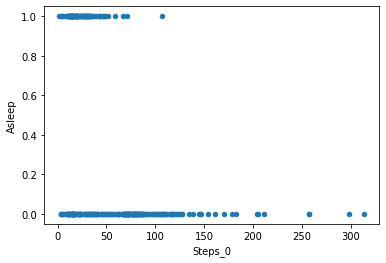

In [200]:
train_data.iloc[:300].plot.scatter(x = 'Steps_0', y = 'Asleep')

In [201]:
train_data.corr()

,Steps_-4,Steps_-3,Steps_-2,Steps_-1,Steps_0,Steps_1,Steps_2,Asleep
Steps_-4,1.000000,0.936517,0.811891,0.654307,0.491140,0.368875,0.267467,-0.165622
Steps_-3,0.936517,1.000000,0.936528,0.811891,0.654387,0.491224,0.368926,-0.177732
Steps_-2,0.811891,0.936528,1.000000,0.936531,0.811960,0.654463,0.491297,-0.190325
Steps_-1,0.654307,0.811891,0.936531,1.000000,0.936576,0.812015,0.654535,-0.203642
Steps_0,0.491140,0.654387,0.811960,0.936576,1.000000,0.936578,0.812023,-0.217681
Steps_1,0.368875,0.491224,0.654463,0.812015,0.936578,1.000000,0.936579,-0.225893
Steps_2,0.267467,0.368926,0.491297,0.654535,0.812023,0.936579,1.000000,-0.228046
Asleep,-0.165622,-0.177732,-0.190325,-0.203642,-0.217681,-0.225893,-0.228046,1.000000


# Regression

In [202]:
X = np.array(train_data.iloc[:, :-1])

In [203]:
y = np.array(train_data.iloc[:, -1])

In [204]:
reg = LogisticRegression().fit(X, y)

In [205]:
reg.score(X, y)

0.8456819429152483

In [206]:
reg.coef_

array([[-0.00202011, -0.00010518, -0.00540047,  0.00300866, -0.01085804,
        -0.01120514, -0.0359073 ]])

In [207]:
reg.intercept_

array([1.94001901])

In [208]:
y_hat = reg.predict(X)

In [209]:
visualize_data = train_data.copy()

In [210]:
visualize_data['Prediction'] = y_hat

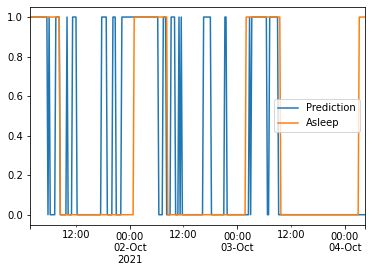

In [211]:
visualize_data[['Prediction', 'Asleep']].loc[0].iloc[:300].plot()

In [212]:
import matplotlib.pyplot as plt

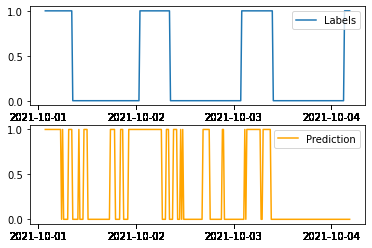

In [243]:
f, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(visualize_data['Asleep'].loc[0].iloc[:300], label = 'Labels') 
ax2.plot(visualize_data['Prediction'].loc[0].iloc[:300], color = 'orange', label = 'Prediction')

ax1.legend()
ax2.legend()

xs = [x.date() for x in visualize_data.loc[0].iloc[:300].index]
plt.setp((ax1, ax2), xticks = xs)

plt.savefig("LogisticRegressionPredictions.png")

[datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 10, 1),
 datetime.date

In [163]:
p_hat = reg.decision_function(X)
p_hat = 1/(1+np.exp(-p_hat))

In [164]:
p_hat

array([0.54024199, 0.50062177, 0.64845318, ..., 0.0671904 , 0.03985641,
       0.06205164])

In [165]:
visualize_data['P_hat'] = p_hat

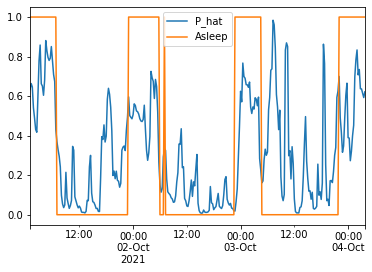

In [166]:
visualize_data[['P_hat', 'Asleep']].loc[50].iloc[:300].plot()

In [167]:
labelled_data

Steps  Asleep
Student ID Datetime                             
0          2021-10-01 00:00:00       NaN       0
           2021-10-01 00:15:00       NaN       0
           2021-10-01 00:30:00       NaN       0
           2021-10-01 00:45:00  3.921973       0
           2021-10-01 01:00:00  3.970292       0
...                                  ...     ...
99         2021-10-31 22:45:00  3.056357       0
           2021-10-31 23:00:00  4.880906       0
           2021-10-31 23:15:00  4.971548       0
           2021-10-31 23:30:00  4.971548       0
           2021-10-31 23:45:00  4.877104       0

[297600 rows x 2 columns]

In [168]:
import matplotlib.pyplot as plt

In [187]:
xs = [np.array([3.76, 3.76, 3.76, 3.76, 0.02 * x, 3.76, 3.76]) for x in range(0, 400)]
ys = [1 / (1 + np.exp(- reg.decision_function(np.reshape(x, (1, -1))))) for x in xs]

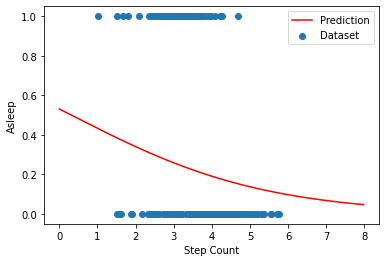

In [189]:
plt.scatter(x = labelled_data.iloc[:300]['Steps'], y = labelled_data.iloc[:300]['Asleep'], label = 'Dataset')
plt.xlabel('Step Count') 
plt.ylabel('Asleep')
plt.plot([0.02 * x for x in range(0, 400)], ys, color = 'r', label = 'Prediction')
plt.legend()

plt.savefig("LogisticRegressionCurve.png")

In [186]:
train_data['Steps_-4'].mean()

3.763652346951136